In [560]:
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_palette('muted')
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,\
AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, \
RandomForestClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

## Webscraping

### IMDB: Get film ids

In [3]:
# Function that will make an api call to omdbapi.com and return film id

def get_id_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

entries = get_id_250()

In [4]:
print len(entries)
print entries[:2]

250
[u'tt2582802', u'tt0047478']


### Fill in film data from omdapi.com

In [5]:
# Function that will make an api call to omdbapi.com and return film data by film id
"""  
     Decided to include full plot summary in case I choose to use NLTK for predicting in future
     Decided to include Rotten Tomatoes ratings and metrics as it may also be a useful feature in models 
"""

# From JSON/APIs lab
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry+'&plot=full&r=json&tomatoes=true')
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [6]:
len(entries_dict_list)

250

In [7]:
df = pd.DataFrame(entries_dict_list)
df.head(1)

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoFresh,tomatoImage,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,246,certified,94,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092


In [8]:
print df.shape

(250, 35)


### IMDB: Get gross, opening weekend and budget

In [9]:
def get_gross(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        gross_list = re.findall("Gross:</h4>[ ]*\$([^ ]*)", html)
        gross = int(gross_list[0].replace(',', ''))
        print '.',
        return gross
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [10]:
grosses = [(e, get_gross(e)) for e in entries]

. . . . . . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200
. . . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
. .
list index out of range tt0053125 200
. . .
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200
. . .
list index out of range tt0072684 200
.
list index out of range tt0074958 200
. . . .
list index out of range tt0036775 200
. . . . . .
list index out of range tt0978762 200

list index out of range tt0109117 200
. .
list index out of range tt0080678 200
. .
list index out of range tt0056592 200
.
list index out of range tt0095327 200
. . .
list index out of range tt0476735 200
. . . . . .
list index out of range tt0046438 200
.
list index out of range tt0015864 200
.
list index out of range tt0045152 200
. . . .
list index out of range tt0046911 200
.
l

In [11]:
df1 = pd.DataFrame(grosses, columns=['imdbID', 'Gross'])
df1.head(3)

,imdbID,Gross
0,tt2582802,13092000.0
1,tt0047478,269061.0
2,tt0082971,242374454.0


In [12]:
def get_opening(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        opening_list = re.findall("Opening Weekend:</h4>[ ]*\$([^ ]*)", html)
        opening = int(opening_list[0].replace(',', ''))
        print '.',
        return opening
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [13]:
opening = [(e, get_opening(e)) for e in entries]

. . .
list index out of range tt0050212 200

list index out of range tt0986264 200
. .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200

list index out of range tt0114746 200
. . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
.
list index out of range tt1187043 200

list index out of range tt0053125 200
.
list index out of range tt0112471 200
.
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200

list index out of range tt0088247 200
.
list index out of range tt0087843 200

list index out of range tt0072684 200
.
list index out of range tt0074958 200
.
list index out of range tt0052618 200
. .
list index out of range tt0036775 200
.
list index out of range tt0110357 200
. . .
list index out of range tt0075148 200

list index out of range tt0978762 200

list index out of r

In [14]:
df2 = pd.DataFrame(opening, columns=['imdbID', 'Opening'])
df2.head(3)

,imdbID,Opening
0,tt2582802,135388.0
1,tt0047478,21830.0
2,tt0082971,1673731.0


In [15]:
def get_budget(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        budget_list = re.findall("Budget:</h4>[ ]*\$([^ ]*)", html)
        budget = int(budget_list[0].replace(',', ''))
        print '.',
        return budget
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [16]:
budgets = [(e, get_budget(e)) for e in entries]

. . . .
list index out of range tt0986264 200
. .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . . . . . .
list index out of range tt0363163 200
.
list index out of range tt1865505 200
. . . . .
list index out of range tt1187043 200
. . . . . . . . . . . . . . . . . . . . . . .
list index out of range tt0071853 200
. .
list index out of range tt0978762 200

list index out of range tt0109117 200
. . . . . . . . . . .
list index out of range tt0476735 200
.
list index out of range tt0044741 200
. . . .
list index out of range tt0046438 200
. . . . . . . .
list index out of range tt0046911 200
.
list index out of range tt0050986 200
.
list index out of range tt0091251 200
. . . . .
list index out of range tt0113247 200
. . . . . . . . . . .
list index out of range tt0060827 200
. .
list index out of range tt0211915 200
. . . . . . .
list index out of range tt0053198 200
. . . . . . . . . .
list index out of range tt0041546 200
. . . . . .
list index o

In [17]:
df3 = pd.DataFrame(budgets, columns=['imdbID', 'Budget'])
df3.head()

,imdbID,Budget
0,tt2582802,3300000.0
1,tt0047478,2000000.0
2,tt0082971,18000000.0
3,tt0050212,3000000.0
4,tt0986264,NaN


In [18]:
print df1.columns
print df2.columns
print df3.columns

Index([u'imdbID', u'Gross'], dtype='object')
Index([u'imdbID', u'Opening'], dtype='object')
Index([u'imdbID', u'Budget'], dtype='object')


In [19]:
df_gross = df1.copy()
df_opening = df2.copy()
df_budget = df3.copy()

In [20]:
print df_gross.columns, df_gross.shape
print df_opening.columns, df_opening.shape
print df_budget.columns, df_opening.shape

Index([u'imdbID', u'Gross'], dtype='object') (250, 2)
Index([u'imdbID', u'Opening'], dtype='object') (250, 2)
Index([u'imdbID', u'Budget'], dtype='object') (250, 2)


### Merge all dataframes into 1 master df

In [21]:
# Merge gross, opening and budget dfs
df_imdb = pd.merge(df_gross, df_opening, on="imdbID")
df_imdb = pd.merge(df_imdb, df_budget, on="imdbID")
df_imdb.head(3)

,imdbID,Gross,Opening,Budget
0,tt2582802,13092000.0,135388.0,3300000.0
1,tt0047478,269061.0,21830.0,2000000.0
2,tt0082971,242374454.0,1673731.0,18000000.0


In [22]:
# Merge original df (from omdbapi) with df_imdb
df = pd.merge(df, df_imdb)
print df.shape
df.head(3)

(250, 38)


,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Gross,Opening,Budget
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092,13092000.0,135388.0,3300000.0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,N/A,Japan,01 Mar 1999,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",...,9.3,57,0,http://www.rottentomatoes.com/m/1018639-seven_...,97,4.5,89264,269061.0,21830.0,2000000.0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,N/A,USA,21 Oct 2003,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,...,9.2,71,4,http://www.rottentomatoes.com/m/raiders_of_the...,96,4.1,823404,242374454.0,1673731.0,18000000.0


In [24]:
#################
#################

# Copy of merged raw dfs without dropping/rearranging columns or cleaning
#dfc1 = df.copy()

#################
#################

In [25]:
#df.to_csv('film_df_v6.csv', sep=',', encoding='utf-8')

### Reorder and drop columns

In [34]:
df.columns = [i.encode("utf-8") for i in df.columns]
df.columns.values

array(['imdbID', 'Title', 'BoxOffice', 'Gross', 'Opening', 'Budget',
       'Year', 'Released', 'Metascore', 'imdbRating', 'imdbVotes',
       'tomatoMeter', 'tomatoRating', 'tomatoReviews', 'tomatoUserMeter',
       'tomatoUserRating', 'tomatoUserReviews', 'tomatoFresh',
       'tomatoRotten', 'Awards', 'Actors', 'Director', 'Writer',
       'Production', 'Country', 'Language', 'Genre', 'Rated', 'Runtime',
       'Plot'], dtype=object)

In [35]:
original_cols = df.columns.values
cols_list = [
    'imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot', 
    'tomatoConsensus', 'tomatoImage',  'tomatoURL',
    'Website',  'DVD',  'Poster', 'Type', 'Response']

# columns to delete:
# ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
# 'Type', 'Poster', 'Website', 'DVD']

print len(original_cols)
print len(cols_list)

30
38


In [ ]:
print df['Type'].value_counts()
print df['Response'].value_counts()

In [29]:
# Reindex column order
df = df.reindex(columns=cols_list)
print df.shape
print df.columns.values
df.head(1)

(250, 38)
['imdbID' 'Title' 'BoxOffice' 'Gross' 'Opening' 'Budget' 'Year' 'Released'
 'Metascore' 'imdbRating' 'imdbVotes' 'tomatoMeter' 'tomatoRating'
 'tomatoReviews' 'tomatoUserMeter' 'tomatoUserRating' 'tomatoUserReviews'
 'tomatoFresh' 'tomatoRotten' 'Awards' 'Actors' 'Director' 'Writer'
 'Production' 'Country' 'Language' 'Genre' 'Rated' 'Runtime' 'Plot'
 'tomatoConsensus' 'tomatoImage' 'tomatoURL' 'Website' 'DVD' 'Poster'
 'Type' 'Response']


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Runtime,Plot,tomatoConsensus,tomatoImage,tomatoURL,Website,DVD,Poster,Type,Response
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,107 min,A promising young drummer enrolls at a cut-thr...,"Intense, inspiring, and well-acted, Whiplash i...",certified,http://www.rottentomatoes.com/m/whiplash_2014/,http://sonyclassics.com/whiplash/,24 Feb 2015,https://images-na.ssl-images-amazon.com/images...,movie,True


In [30]:
cols_to_delete = ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
                  'Type', 'Poster', 'Website', 'DVD']

In [31]:
# Create final master df with only 30 columns
df = df[['imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot']]

print df.shape
df.head(2)

(250, 30)


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Actors,Director,Writer,Production,Country,Language,Genre,Rated,Runtime,Plot
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Damien Chazelle,Damien Chazelle,Sony Pictures Classics,USA,English,"Drama, Music",R,107 min,A promising young drummer enrolls at a cut-thr...
1,tt0047478,Seven Samurai,N/A,269061.0,21830.0,2000000.0,1954,19 Nov 1956,98,8.7,...,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Akira Kurosawa,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",Columbia Pictures,Japan,Japanese,"Action, Adventure, Drama",UNRATED,207 min,"A veteran samurai, who has fallen on hard time..."


In [32]:
#######################
#######################

# Copy of merged df with columns cleaned
#dfc2 = df.copy()

#######################
#######################

In [33]:
#df.to_csv('film_df_v6_2.csv', sep=',', encoding='utf-8')

## Data Cleaning / Munging

### Converting dtypes

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 30 columns):
imdbID               250 non-null object
Title                250 non-null object
BoxOffice            250 non-null object
Gross                183 non-null float64
Opening              118 non-null float64
Budget               213 non-null float64
Year                 250 non-null object
Released             250 non-null object
Metascore            250 non-null object
imdbRating           250 non-null object
imdbVotes            250 non-null object
tomatoMeter          250 non-null object
tomatoRating         250 non-null object
tomatoReviews        250 non-null object
tomatoUserMeter      250 non-null object
tomatoUserRating     250 non-null object
tomatoUserReviews    250 non-null object
tomatoFresh          250 non-null object
tomatoRotten         250 non-null object
Awards               250 non-null object
Actors               250 non-null object
Director             250 non-nu

### Convert numeric dtypes (floats and int)

In [411]:
# Convert Metascore to float with np.nan for N/A
df['Metascore'] = df['Metascore'].apply(lambda x: np.nan if x == 'N/A' else x)
df['Metascore'] = df['Metascore'].astype(float)

In [412]:
# Convert imdbRating to float
df['imdbRating'] = df['imdbRating'].astype(float)

In [413]:
# Convert imdbVotes to int
df['imdbVotes'] = df['imdbVotes'].apply(lambda x: x.replace(',', ''))
df['imdbVotes'] = df['imdbVotes'].astype(int)

In [ ]:
# Convert all tomato columns to int
tomato_list = ['tomatoMeter', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserReviews',
           'tomatoFresh', 'tomatoRotten', 'tomatoRating', 'tomatoUserRating']

def convert_num(some_list):
    for i in some_list:
        df[i] = df[i].apply(lambda x: np.nan if x == 'N/A' else x)
        df[i] = df[i].astype(float)
    return df[i]

convert_num(tomato_list)

### Unused tomato convert cells

In [ ]:
# Convert tomatoRating to float

In [ ]:
# Convert tomatoReviews to int

In [ ]:
# Convert tomatoUserMeter to int

In [ ]:
# Convert tomatoUserRating to float

In [ ]:
# Convert tomatoUserReviews to int

In [ ]:
# Convert tomatoFresh to int

In [ ]:
# Convert tomatoRotten to int

In [ ]:
# Convert

### Convert datetime-related columns (Year, Released and Runtime)

In [415]:
# Convert Year to int
df['Year'] = df['Year'].astype(int)

In [416]:
# Convert Release to datetime

# Only N/A value is Charlie Chaplin's The Gold Rush
df['Release'] = ['1925-06-25' if i=='N/A' else datetime.strptime(i, '%d %b %Y') \
                 for i in df['Released']]
df['Release'].head(3)

0   2014-10-15
1   1956-11-19
2   1981-06-12
Name: Release, dtype: datetime64[ns]

In [417]:
# Extract month from release date
df['Month'] = [x[3:6] for x in df['Released']]

In [418]:
# Create new season bins for release dates

# Only missing value is Charlie Chaplin's The Gold Rush
winter = ['Jan', 'Feb', 'Mar', 'Apr']
summer = ['May', 'Jun', 'Jul']
fall = ['Aug', 'Sep', 'Oct']
holiday = ['Nov', 'Dec']

def bin_months(i):
    if i in winter:
        i = 'Winter'
    elif i in summer:
        i = 'Summer'
    elif i in fall:
        i = 'Fall'
    elif i in holiday:
        i = 'Holiday'
    else:
        i = 'Summer'
    return i

df['Season'] = [bin_months(x) for x in df['Month']]
df['Season'].value_counts()

Winter     82
Fall       60
Summer     58
Holiday    50
Name: Season, dtype: int64

In [419]:
# Convert Runtime to int
def runtime_int(x):
    return int(x.replace(' min', ''))

df['Runtime'] = df['Runtime'].apply(runtime_int)
df['Runtime'].head(2)

0    107
1    207
Name: Runtime, dtype: int64

### Clean up Awards, Rating and Genres

In [420]:
df['Awards'].head()

0     Won 3 Oscars. Another 87 wins & 131 nominations.
1    Nominated for 2 Oscars. Another 5 wins & 6 nom...
2      Won 4 Oscars. Another 30 wins & 23 nominations.
3       Won 7 Oscars. Another 23 wins & 7 nominations.
4                            14 wins & 15 nominations.
Name: Awards, dtype: object

In [421]:
# Make Oscars_Won column with number of Oscars won
def oscar_winners(x):
    try:
        oscar_winner = re.findall(r'([^.]*?Oscar[^.]*\.)',x)[0].split()
        if type(oscar_winner[0]) == int:
            return int(oscar_winner[0])
        elif oscar_winner[0] == 'Won':
            return int(oscar_winner[1])
        else:
            return 0
    except:
        return 0
    
df['Oscars_Won'] = df['Awards'].apply(oscar_winners)
df['Oscars_Won'].head(3)

0    3
1    0
2    4
Name: Oscars_Won, dtype: int64

In [422]:
# Make Oscar_Noms columns
def oscar_noms(x):
    try:
        oscar_noms = re.findall('Nominated\sfor\s(\d)\sOscar',x)[0]
        return int(oscar_noms)
    except:
        return 0

df['Oscar_Noms'] = df['Awards'].apply(oscar_noms)
df['Oscar_Noms'].value_counts()

0    179
1     28
2     12
4      9
3      8
5      6
7      4
6      3
8      1
Name: Oscar_Noms, dtype: int64

In [423]:
# Make Awards_Won column with sum of other awards won
def awards_won(x):
    try:
        awards_won = re.findall('Another\s(\d+)\swins', x)[0]
        return int(awards_won)
    except:
        return 0

df['Awards_Won'] = df['Awards'].apply(awards_won)
df['Awards_Won'].head(3)

0    87
1     5
2    30
Name: Awards_Won, dtype: int64

In [424]:
# Make Other_Noms column with sum of other nominations
def other_noms(x):
    try:
        other_noms = re.findall('(\d+)\snomination', x)[0]
        return int(other_noms)
    except:
        return 0

df['Other_Noms'] = df['Awards'].apply(other_noms)
df['Other_Noms'].head(3)

0    131
1      6
2     23
Name: Other_Noms, dtype: int64

In [425]:
# Clean up Rating column
print df['Rated'].value_counts()
rated_other = ['NOT RATED', 'APPROVED', 'UNRATED', 'PASSED', 'N/A', 'M']

df['Rated'] = df['Rated'].apply(lambda x: x if x not in rated_other else 'OTHER')
df['Rated'].value_counts()

R            106
PG            38
PG-13         32
NOT RATED     26
APPROVED      19
G             12
UNRATED        9
PASSED         5
N/A            2
M              1
Name: Rated, dtype: int64


R        106
OTHER     62
PG        38
PG-13     32
G         12
Name: Rated, dtype: int64

In [426]:
# Clean up Genre column
df['Genre_1'] = df['Genre'].apply(lambda x: x.split(',')[0])
df['Genre_1'].value_counts()

Drama        69
Crime        39
Action       34
Adventure    28
Comedy       26
Biography    21
Animation    19
Mystery       5
Horror        3
Western       3
Film-Noir     2
Sci-Fi        1
Name: Genre_1, dtype: int64

In [427]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 38 columns):
imdbID               250 non-null object
Title                250 non-null object
BoxOffice            250 non-null object
Gross                183 non-null float64
Opening              118 non-null float64
Budget               213 non-null float64
Year                 250 non-null int64
Released             250 non-null object
Metascore            167 non-null float64
imdbRating           250 non-null float64
imdbVotes            250 non-null int64
tomatoMeter          243 non-null float64
tomatoRating         243 non-null float64
tomatoReviews        243 non-null float64
tomatoUserMeter      247 non-null float64
tomatoUserRating     247 non-null float64
tomatoUserReviews    249 non-null float64
tomatoFresh          243 non-null float64
tomatoRotten         243 non-null float64
Awards               250 non-null object
Actors               250 non-null object
Director             25

In [428]:
#######################
#######################

# Copy of cleaned df
#dfc3 = df.copy()

#######################
#######################

### Convert all dtype object columns to strings

In [333]:
#####################
#####################
# DO NOT RUN!!!
objects = [x for x in df.columns if df[x].dtype == 'object']
def objects_to_string(x):
    return str(x)

def df_to_string():
    for i in objects:
        return objects_to_string(df[i])

df_to_string()

'0      tt2582802\n1      tt0047478\n2      tt0082971\n3      tt0050212\n4      tt0848228\n5      tt1663202\n6      tt0338564\n7      tt0046268\n8      tt0055630\n9      tt0266543\n10     tt0042192\n11     tt0198781\n12     tt1979320\n13     tt0405159\n14     tt0057115\n15     tt0253474\n16     tt0071315\n17     tt0114746\n18     tt0363163\n19     tt0119217\n20     tt1865505\n21     tt0074896\n22     tt1895587\n23     tt0347149\n24     tt0021749\n25     tt0119488\n26     tt1187043\n27     tt0053125\n28     tt0268978\n29     tt0112471\n         ...    \n220    tt0043014\n221    tt0079944\n222    tt0093058\n223    tt0053604\n224    tt0109830\n225    tt0118799\n226    tt0073195\n227    tt0169547\n228    tt1392214\n229    tt0051201\n230    tt0075686\n231    tt0032976\n232    tt1375666\n233    tt0059578\n234    tt0072890\n235    tt0076759\n236    tt0103064\n237    tt0056801\n238    tt0395169\n239    tt0031381\n240    tt0477348\n241    tt0047296\n242    tt1028532\n243    tt0120815\n244    tt

### Fill in missing values

In [529]:
df.isnull().sum()

imdbID                 0
Title                  0
BoxOffice              0
Gross                 67
Opening              132
Budget                37
Year                   0
Released               0
Metascore             83
imdbRating             0
imdbVotes              0
tomatoMeter            7
tomatoRating           7
tomatoReviews          7
tomatoUserMeter        3
tomatoUserRating       3
tomatoUserReviews      1
tomatoFresh            7
tomatoRotten           7
Awards                 0
Actors                 0
Director               0
Writer                 0
Production             0
Country                0
Language               0
Genre                  0
Rated                  0
Runtime                0
Plot                   0
Release                0
Month                  0
Season                 0
Oscars_Won             0
Oscar_Noms             0
Awards_Won             0
Other_Noms             0
Genre_1                0
dtype: int64

In [530]:
# Drop columns with a large proportion of missing values 
# (columns whose values are difficult to impute)
# Also drop Language column as most
cols_to_drop2 = ['Metascore', 'Opening', 'Budget', 'Language']
df.drop(['Metascore', 'Opening', 'Budget', 'Language'], axis=1, inplace=True)

In [531]:
# For columns with small number of missing values, fill missing values
# with median column values

df['tomatoMeter'].fillna((df['tomatoMeter'].median()), inplace=True)
df['tomatoRating'].fillna((df['tomatoRating'].median()), inplace=True)
df['tomatoReviews'].fillna((df['tomatoReviews'].median()), inplace=True)
df['tomatoUserMeter'].fillna((df['tomatoUserMeter'].median()), inplace=True)
df['tomatoUserRating'].fillna((df['tomatoUserRating'].median()), inplace=True)
df['tomatoUserReviews'].fillna((df['tomatoUserReviews'].median()), inplace=True)
df['tomatoFresh'].fillna((df['tomatoFresh'].median()), inplace=True)
df['tomatoRotten'].fillna((df['tomatoRotten'].median()), inplace=True)

df.isnull().sum()

imdbID                0
Title                 0
BoxOffice             0
Gross                67
Year                  0
Released              0
imdbRating            0
imdbVotes             0
tomatoMeter           0
tomatoRating          0
tomatoReviews         0
tomatoUserMeter       0
tomatoUserRating      0
tomatoUserReviews     0
tomatoFresh           0
tomatoRotten          0
Awards                0
Actors                0
Director              0
Writer                0
Production            0
Country               0
Genre                 0
Rated                 0
Runtime               0
Plot                  0
Release               0
Month                 0
Season                0
Oscars_Won            0
Oscar_Noms            0
Awards_Won            0
Other_Noms            0
Genre_1               0
dtype: int64

### Try to fill in missing values for Gross column with linear regression

In [395]:
summary = df.describe()
summary1 = pd.DataFrame(summary.loc[:, 'Gross'].apply(lambda x: '{0: ,.2f}'.format(x)))
summary1

,Gross
count,183.00
mean,"105,567,126.31"
std,"134,133,176.66"
min,"10,177.00"
25%,"8,581,698.50"
50%,"52,287,414.00"
75%,"161,202,324.00"
max,"936,627,416.00"


In [639]:
lm_test = df[df['Gross'].notnull() == True] 
lm_pred = df[df['Gross'].notnull() == False] 

In [618]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lm = LinearRegression()
X = lm_test[['imdbRating', 'imdbVotes', 'tomatoMeter', \
              'tomatoRating', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserRating', \
              'tomatoUserReviews', 'tomatoFresh', 'tomatoRotten', 'Year', 'Oscars_Won', \
            'Oscar_Noms', 'Awards_Won', 'Other_Noms', 'Runtime']]
y = lm_test['Gross']

linear = lm.fit(X, y)
y_pred = linear.predict(X)


print 'model_score:', linear.score(X, y)
print 'MSE:', mean_squared_error(y, y_pred)
print 'coeffs: ', linear.coef_
print ''
print '***Note: Model score is too low to predict missing gross revenue values***'

model_score: 0.531888862681
MSE: 8.37609688985e+15
coeffs:  [ -1.38219887e+08   2.62173393e+02   2.79865945e+05  -1.56789557e+07
   1.74463386e+07  -2.07664272e+06   7.45621527e+07  -2.46101355e-01
  -1.62062691e+07  -1.96188748e+07  -3.34552246e+05   1.60532152e+07
   8.46109770e+06  -7.34879751e+05  -7.22682733e+05  -3.59189186e+04]

***Note: Model score is too low to predict missing gross revenue values***


#### Model score of 0.5319 is too low to predict missing gross values

### Unused Fill in missing Gross values

In [660]:
df['Gross'].isnull().sum()

67

In [ ]:
# Trying to fill Gross na's with BoxOffice does not help at all
df['Gross'].fillna(value=df['BoxOffice'])

In [656]:
title_list = [i for i in missing_gross['Title']]
title_list

[u'The Wages of Fear',
 u'Yojimbo',
 u'The Great Escape',
 u'Chinatown',
 u'The Message',
 u'City Lights',
 u'North by Northwest',
 u'Ip Man',
 u'It Happened One Night',
 u'Fanny and Alexander',
 u'Barry Lyndon',
 u'Network',
 u'Double Indemnity',
 u'Mary and Max',
 u'Andaz Apna Apna',
 u'The Elephant Man',
 u'To Kill a Mockingbird',
 u'Grave of the Fireflies',
 u'My Father and My Son',
 u'Tokyo Story',
 u'The Gold Rush',
 u"Singin' in the Rain",
 u'Diabolique',
 u'Wild Strawberries',
 u'Come and See',
 u'The Great Dictator',
 u'The Grapes of Wrath',
 u'Persona',
 u'Mr. Smith Goes to Washington',
 u'The 400 Blows',
 u'Paths of Glory',
 u'Rashomon',
 u'Gandhi',
 u'Strangers on a Train',
 u'Kind Hearts and Coronets',
 u'Castle in the Sky',
 u'Gangs of Wasseypur',
 u'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb',
 u'My Neighbor Totoro',
 u'Once Upon a Time in the West',
 u'The Shining',
 u"It's a Wonderful Life",
 u'Casablanca',
 u'Roman Holiday',
 u'The Maltese Fa

In [678]:
dollars = [0, 0, 11744471., 0, 3270000., 0, 9800000., 21889820., 2500000., 6700000., ]

In [679]:
full_list = []
full_list.append(title_list)
full_list.append(dollars)

In [680]:
pd.DataFrame(full_list).T

,0,1
0,The Wages of Fear,0
1,Yojimbo,0
2,The Great Escape,1.17445e+07
3,Chinatown,0
4,The Message,3.27e+06
5,City Lights,0
6,North by Northwest,9.8e+06
7,Ip Man,2.18898e+07
8,It Happened One Night,2.5e+06
9,Fanny and Alexander,6.7e+06


In [652]:
missing_gross_dict = {(k, 0) for k in missing_gross['Title']}

{(u'12 Angry Men', 0),
 (u'A Clockwork Orange', 0),
 (u'Andaz Apna Apna', 0),
 (u'Barry Lyndon', 0),
 (u'Casablanca', 0),
 (u'Castle in the Sky', 0),
 (u'Chinatown', 0),
 (u'Citizen Kane', 0),
 (u'City Lights', 0),
 (u'Come and See', 0),
 (u'Cool Hand Luke', 0),
 (u'Diabolique', 0),
 (u'Dog Day Afternoon', 0),
 (u'Double Indemnity', 0),
 (u'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb', 0),
 (u'Fanny and Alexander', 0),
 (u'For a Few Dollars More', 0),
 (u'Gandhi', 0),
 (u'Gangs of Wasseypur', 0),
 (u'Grave of the Fireflies', 0),
 (u"Hachi: A Dog's Tale", 0),
 (u'Ip Man', 0),
 (u'It Happened One Night', 0),
 (u"It's a Wonderful Life", 0),
 (u'Judgment at Nuremberg', 0),
 (u'Kind Hearts and Coronets', 0),
 (u'Mary and Max', 0),
 (u'Mr. Smith Goes to Washington', 0),
 (u'My Father and My Son', 0),
 (u'My Neighbor Totoro', 0),
 (u'Nausica\xe4 of the Valley of the Wind', 0),
 (u'Network', 0),
 (u'North by Northwest', 0),
 (u'Once Upon a Time in the West', 0),
 (u'Pa

In [640]:
missing_gross = lm_pred[['imdbID', 'Title', 'Gross']].reset_index(drop=True)
missing_gross

,imdbID,Title,Gross
0,tt0046268,The Wages of Fear,NaN
1,tt0055630,Yojimbo,NaN
2,tt0057115,The Great Escape,NaN
3,tt0071315,Chinatown,NaN
4,tt0074896,The Message,NaN
5,tt0021749,City Lights,NaN
6,tt0053125,North by Northwest,NaN
7,tt1220719,Ip Man,NaN
8,tt0025316,It Happened One Night,NaN
9,tt0083922,Fanny and Alexander,NaN


### Fill in missing Gross values with median

In [681]:
df.columns

Index([u'imdbID', u'Title', u'BoxOffice', u'Gross', u'Year', u'Released',
       u'imdbRating', u'imdbVotes', u'tomatoMeter', u'tomatoRating',
       u'tomatoReviews', u'tomatoUserMeter', u'tomatoUserRating',
       u'tomatoUserReviews', u'tomatoFresh', u'tomatoRotten', u'Awards',
       u'Actors', u'Director', u'Writer', u'Production', u'Country', u'Genre',
       u'Rated', u'Runtime', u'Plot', u'Release', u'Month', u'Season',
       u'Oscars_Won', u'Oscar_Noms', u'Awards_Won', u'Other_Noms', u'Genre_1'],
      dtype='object')

## Count Vectorization

In [ ]:
# Actor, Director, Plot, Title, Genre, Production

In [111]:
# CountVectorizer w/parameters
cvec = CountVectorizer(stop_words='english', lowercase=True)

#### Actors

In [112]:
# Create column of first names only
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(',')[0])
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(' ')[0])
print df['Actor_First_Name'].head(3)

# Create column of lead actors only
df['Lead_Actor'] = df['Actors'].apply(lambda x: x.split(',')[0])
print df['Lead_Actor'].head(3)

# Create column of concatenated names to identify unique people
df['Actors'] = df['Actors'].apply(lambda x: x.replace(' ',''))
print df['Actors'].head(3)

0       Miles
1     Toshirô
2    Harrison
Name: Actor_First_Name, dtype: object
0      Miles Teller
1    Toshirô Mifune
2     Harrison Ford
Name: Lead_Actor, dtype: object
0    MilesTeller,J.K.Simmons,PaulReiser,MelissaBenoist
1    ToshirôMifune,TakashiShimura,KeikoTsushima,Yuk...
2      HarrisonFord,KarenAllen,PaulFreeman,RonaldLacey
Name: Actors, dtype: object


In [167]:
actors_df = cvec.fit_transform(df['Actors']).todense()
actor_col = cvec.get_feature_names()
actors_df = pd.DataFrame(actors_df, columns=actor_col)

actors = pd.DataFrame(actors_df.sum())
actors.columns = ['Count']
actors.sort_values(['Count'], ascending=False, inplace=True)
actors.head()

,Count
leonardodicaprio,7
harrisonford,7
robertdeniro,7
clinteastwood,6
tomhanks,6


1    733
2     87
3     19
4      9
7      3
6      2
5      2
Name: Count, dtype: int64
(16, 1)
                  Count
clinteastwood         6
tomhanks              6
leonardodicaprio      7
harrisonford          7
robertdeniro          7


/Users/kristensu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


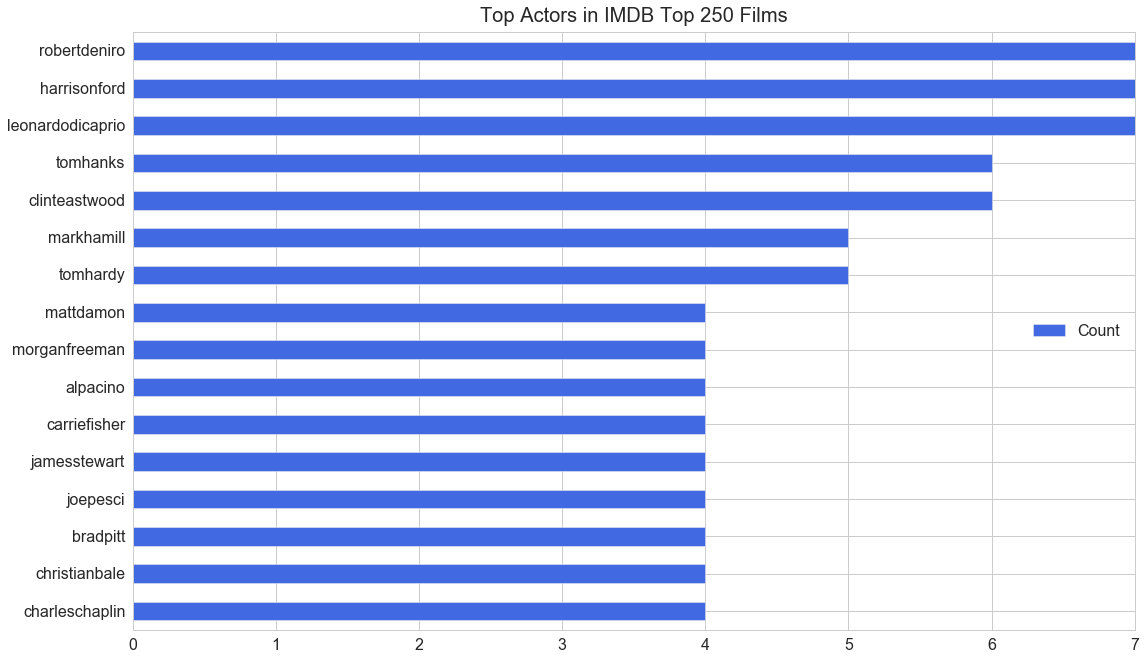

In [206]:
print actors['Count'].value_counts()
top_actors = actors[actors['Count'] > 3]
top_actors.sort_values('Count', ascending=True, inplace=True)
print top_actors.shape
print top_actors.tail()

ax = top_actors.plot(kind='barh', figsize=(16,10), color='royalblue')
ax.set_title('Top Actors in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

          Count
jean          4
robert        5
clint         5
leonardo      6
tom           8
1    129
2     17
3     16
4      4
5      2
8      1
6      1
Name: Count, dtype: int64


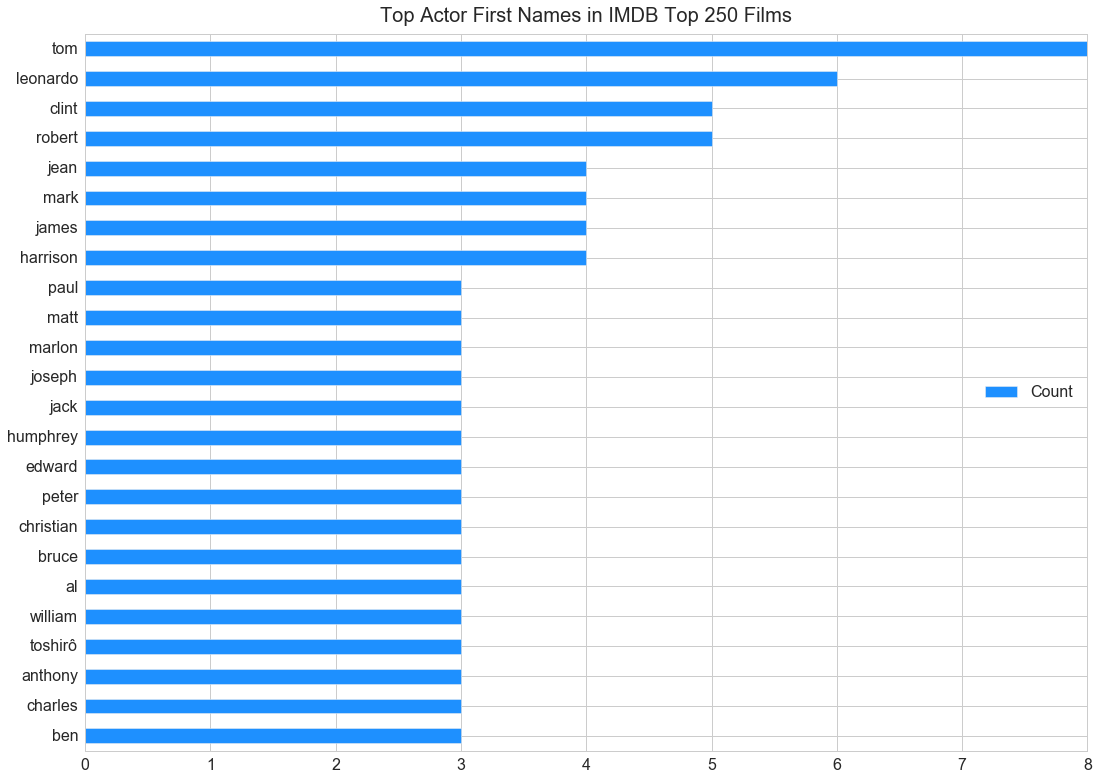

In [207]:
actor_first = cvec.fit_transform(df['Actor_First_Name']).todense()
actor_first_col = cvec.get_feature_names()
actor_first = pd.DataFrame(actor_first, columns=actor_first_col)

actor_first = pd.DataFrame(actor_first.sum())
actor_first.columns = ['Count']
actor_first.sort_values(['Count'], inplace=True)
print actor_first.tail()
print actor_first['Count'].value_counts()

top_actor_first = actor_first[actor_first['Count'] > 2]

"""self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, \
sharey=False, layout=None, figsize=None, use_index=True, title=None, \
grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, \
xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, \
colormap=None, table=False, yerr=None, xerr=None, secondary_y=False, \
sort_columns=False, **kwds"""

ax = top_actor_first.plot(kind='barh', figsize=(16,12), color='dodgerblue')
ax.set_title('Top Actor First Names in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Unused Categorical Histograms

In [ ]:
# Ask how to create barh subplots with categorical histograms

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,30), sharex=True)

ax1.barh( color='royalblue')
ax1.set_title('Top Actors in IMDB Top 250 Films', y=1.01)
ax1.tick_params(labelsize=16)
ax1.legend(fontsize=16, loc='center right')

ax2 = top_actor_first.plot(kind='barh', figsize=(16,12), color='dodgerblue')
ax2.set_title('Top Actor First Names in IMDB Top 250 Films', y=1.01)
ax2.tick_params(labelsize=16)
ax2.legend(fontsize=16, loc='center right')

#### Directors 

1    133
2     23
3     12
7      5
5      4
6      2
4      2
Name: Count, dtype: int64
(13, 1)
                  Count
stevenspielberg       7
christophernolan      7
martinscorsese        7
alfredhitchcock       7
stanleykubrick        7


/Users/kristensu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kristensu/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:325: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  six.iterkeys(self.codes))))


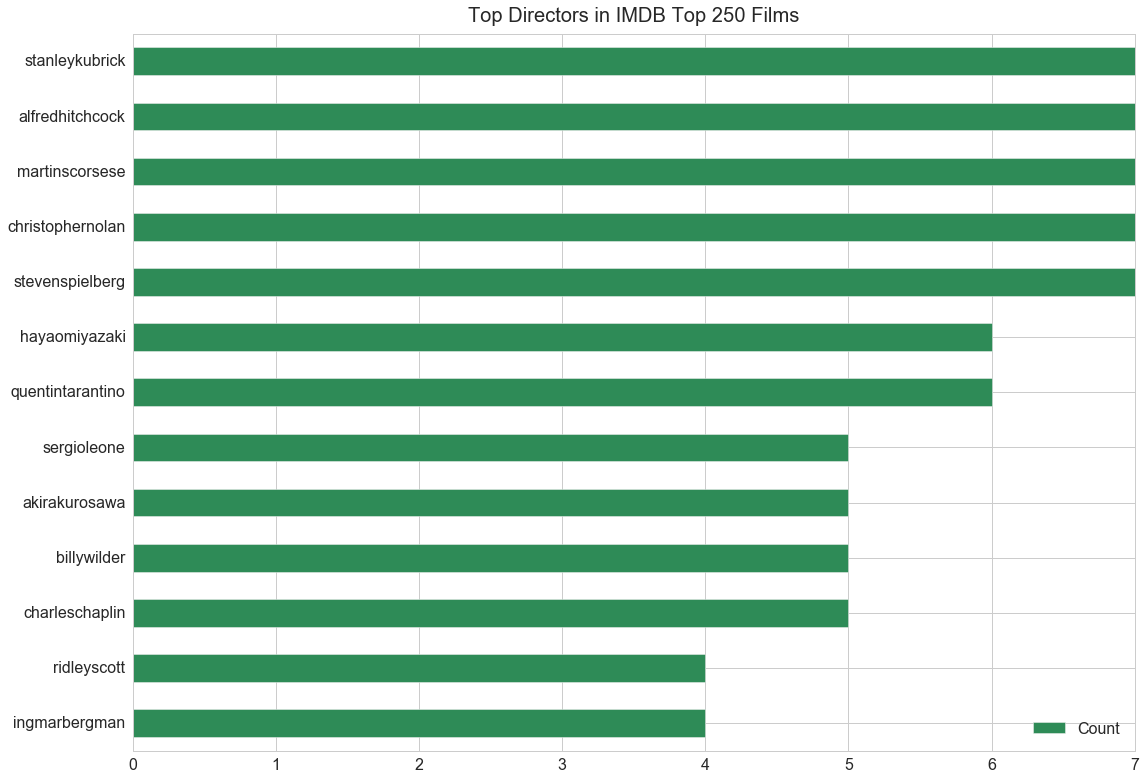

In [219]:
# Create column of concatenated directors to identify unique people
df['Director'] = df['Director'].apply(lambda x: x.replace(' ',''))

directors_df = cvec.fit_transform(df['Director']).todense()
directors_col = cvec.get_feature_names()
directors_df = pd.DataFrame(directors_df, columns=directors_col)
directors = pd.DataFrame(directors_df.sum())
directors.columns = ['Count']
directors.sort_values(['Count'], inplace=True)

print directors['Count'].value_counts()
top_directors = directors[directors['Count'] > 3]
top_directors.sort_values('Count', inplace=True)
print top_directors.shape
print top_directors.tail()

ax = top_directors.plot(kind='barh', figsize=(16,12), color='seagreen')
ax.set_title('Top Directors in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='bottom right')

#### Plot

(36, 1)
        Count
love       26
family     31
police     32
father     33
new        34
war        36
man        40
world      43
young      46
life       66


/Users/kristensu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


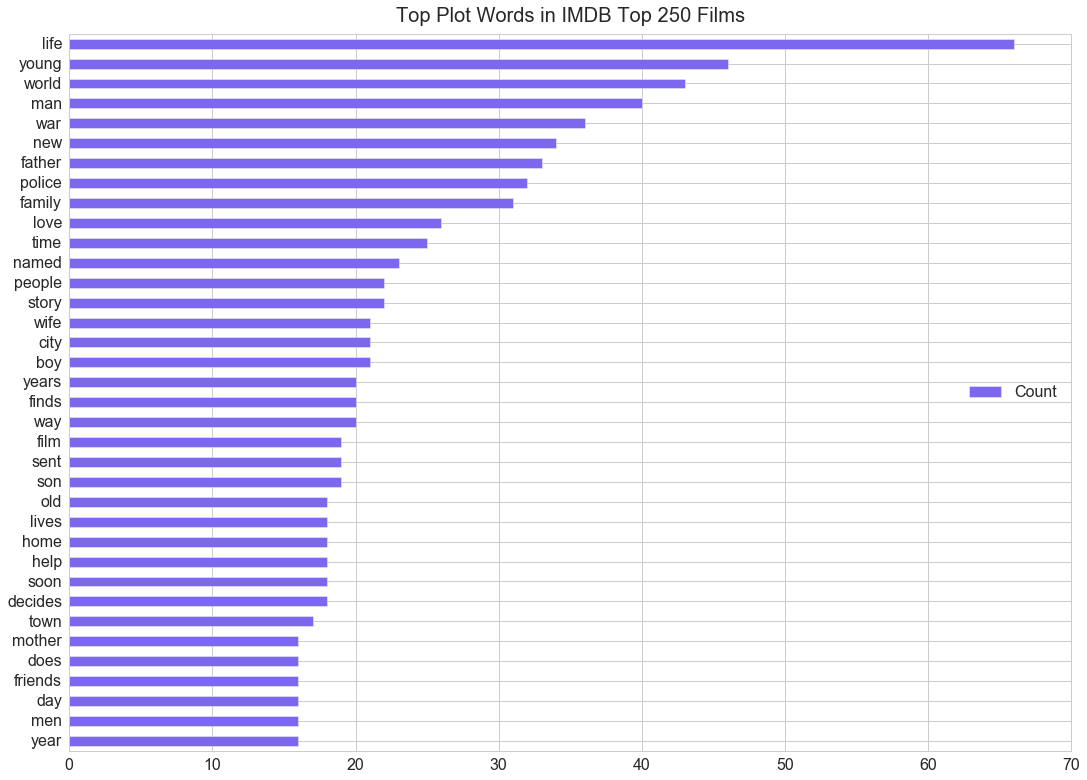

In [235]:
plot_df = cvec.fit_transform(df['Plot']).todense()
plot_col = cvec.get_feature_names()
plot_df = pd.DataFrame(plot_df, columns=plot_col)
plot = pd.DataFrame(plot_df.sum())
plot.columns = ['Count']
plot.sort_values(['Count'], inplace=True)
plot['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_plot = plot[plot['Count'] > 15]
top_plot.sort_values('Count', inplace=True)
print top_plot.shape
print top_plot.tail(10)

ax = top_plot.plot(kind='barh', figsize=(16,12), color='mediumslateblue')
ax.set_title('Top Plot Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Title

(47, 1)
         Count
episode      3
day          3
man          3
life         3
wild         3
king         3
story        3
lord         3
star         4
wars         4


/Users/kristensu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


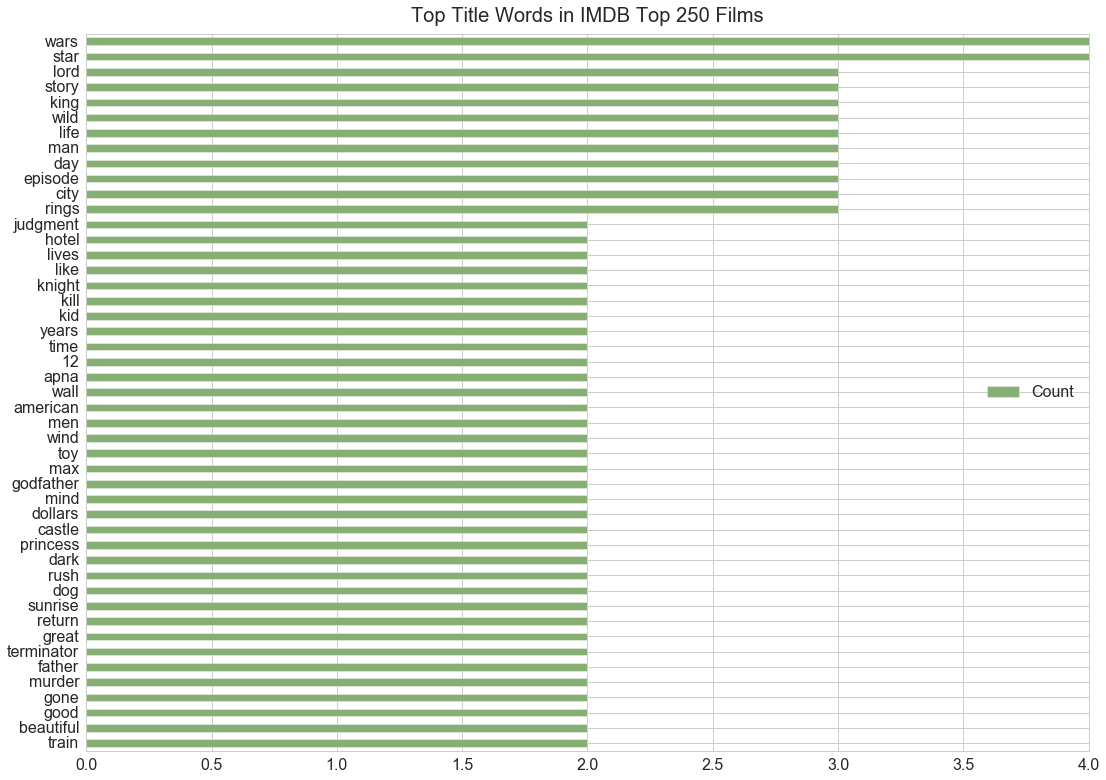

In [252]:
title_df = cvec.fit_transform(df['Title']).todense()
title_col = cvec.get_feature_names()
title_df = pd.DataFrame(title_df, columns=title_col)
title = pd.DataFrame(title_df.sum())
title.columns = ['Count']
title.sort_values(['Count'], inplace=True)
title['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_title = title[title['Count'] > 1]
top_title.sort_values('Count', inplace=True)
print top_title.shape
print top_title.tail(10)

ax = top_title.plot(kind='barh', figsize=(16,12), color='sage')
ax.set_title('Top Title Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Genre

(23, 1)
           Count
sci           22
fantasy       23
biography     26
mystery       30
action        35
thriller      39
comedy        42
crime         55
adventure     61
drama        173


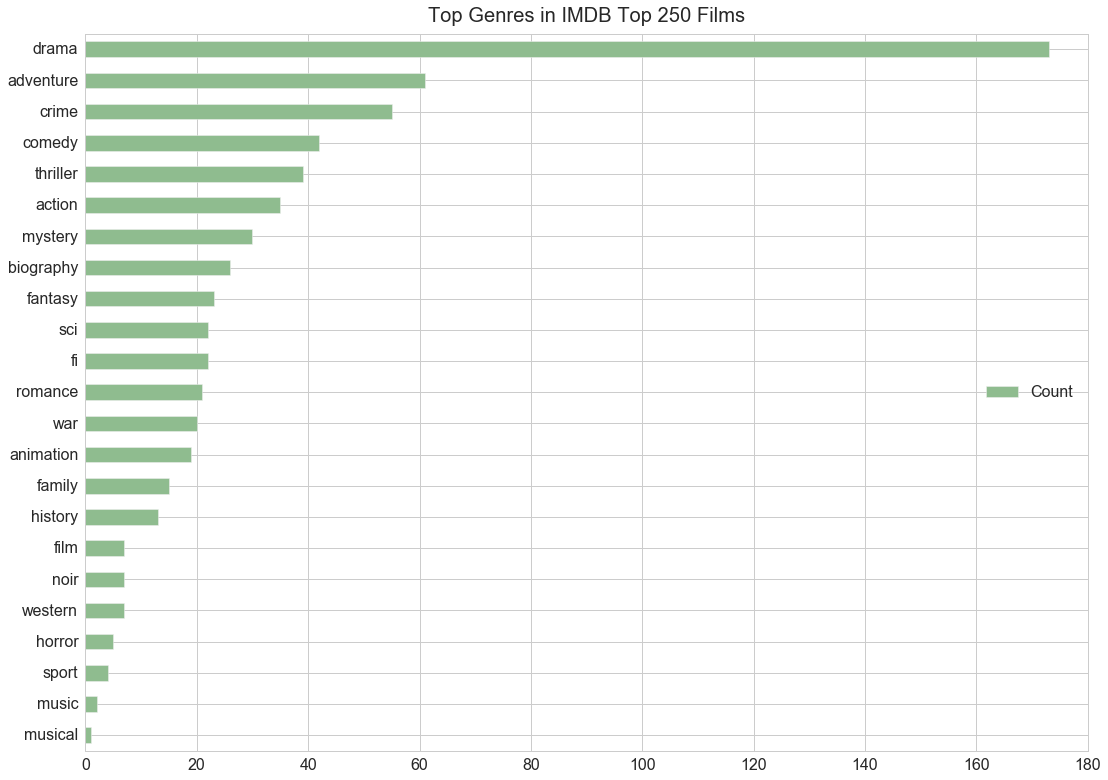

In [258]:
genre_df = cvec.fit_transform(df['Genre']).todense()
genre_col = cvec.get_feature_names()
genre_df = pd.DataFrame(genre_df, columns=genre_col)
genre = pd.DataFrame(genre_df.sum())
genre.columns = ['Count']
genre.sort_values(['Count'], inplace=True)
genre['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_genre = genre[genre['Count'] > 0]
top_genre.sort_values('Count', inplace=True)
print top_genre.shape
print top_genre.tail(10)

ax = top_genre.plot(kind='barh', figsize=(16,12), color='darkseagreen')
ax.set_title('Top Genres in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Production Company

0    SonyPicturesClassics
1        ColumbiaPictures
2       ParamountPictures
Name: Production, dtype: object
(19, 1)
                    Count
mgm                     6
waltdisneypictures      7
miramaxfilms           10
columbiapictures       10
universalpictures      12
20thcenturyfox         12
unitedartists          13
paramountpictures      18
pictures               21
warnerbros             30


/Users/kristensu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


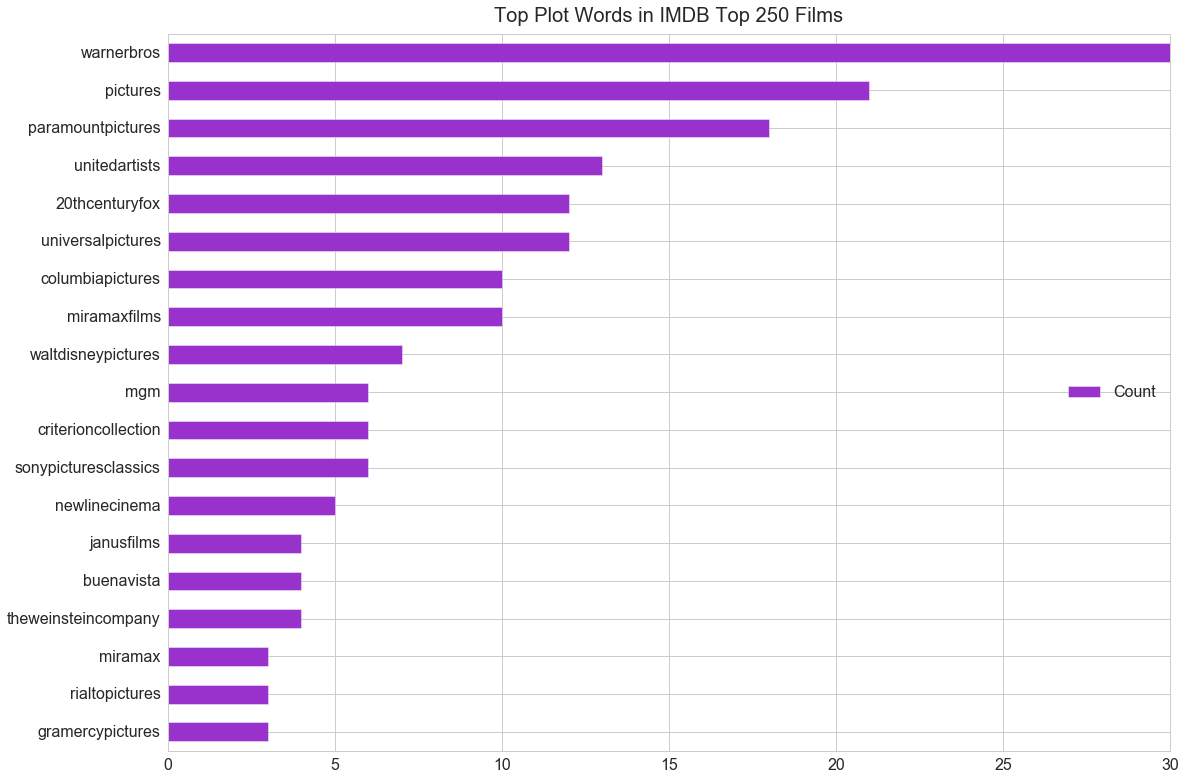

In [270]:
# Create column of concatenated production company names to identify unique companies
df['Production'] = df['Production'].apply(lambda x: x.replace(' ',''))
print df['Production'].head(3)

production_df = cvec.fit_transform(df['Production']).todense()
production_col = cvec.get_feature_names()
production_df = pd.DataFrame(production_df, columns=production_col)
production = pd.DataFrame(production_df.sum())
production.columns = ['Count']
production.sort_values(['Count'], inplace=True)
production['Count'].value_counts().sort_values(ascending=True)

# print production['Count'].value_counts()
top_production = production[production['Count'] > 2]
top_production.sort_values('Count', inplace=True)
print top_production.shape
print top_production.tail(10)

ax = top_production.plot(kind='barh', figsize=(16,12), color='darkorchid')
ax.set_title('Top Plot Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

## EDA

### Histograms

#### Year, Runtime, Gross

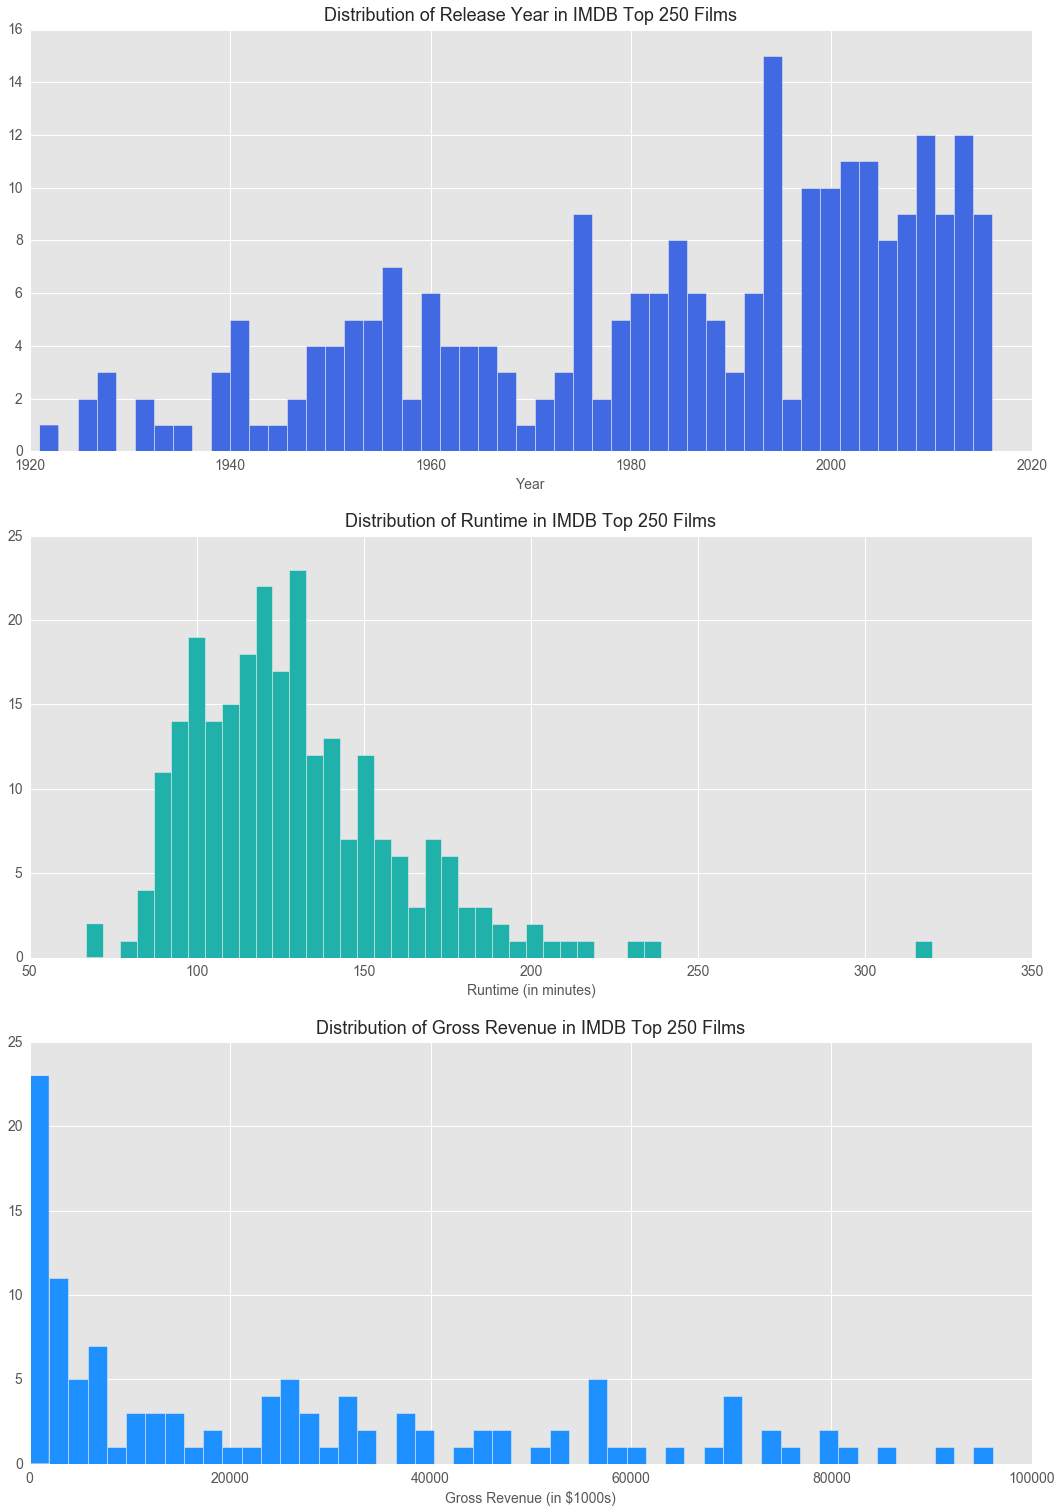

In [326]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,24))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.hist(df['Year'], bins=50, color='royalblue')
ax1.set_title('Distribution of Release Year in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylim(top=16)
ax1.tick_params(labelsize=14)

ax2.hist(df['Runtime'], bins=50, color='lightseagreen')
ax2.set_title('Distribution of Runtime in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax2.set_xlabel('Runtime (in minutes)', fontsize=14)
ax2.tick_params(labelsize=14)

gross_hist = df[df['Gross'] < 100000000]
gross_hist = gross_hist[gross_hist['Gross'] > 0]
ax3.hist(gross_hist['Gross']/1000, bins=50, color='dodgerblue')
ax3.set_title('Distribution of Gross Revenue in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax3.set_xlabel('Gross Revenue (in $1000s)', fontsize=14, y = -2.01)
ax3.tick_params(labelsize=14)

#### Reviews

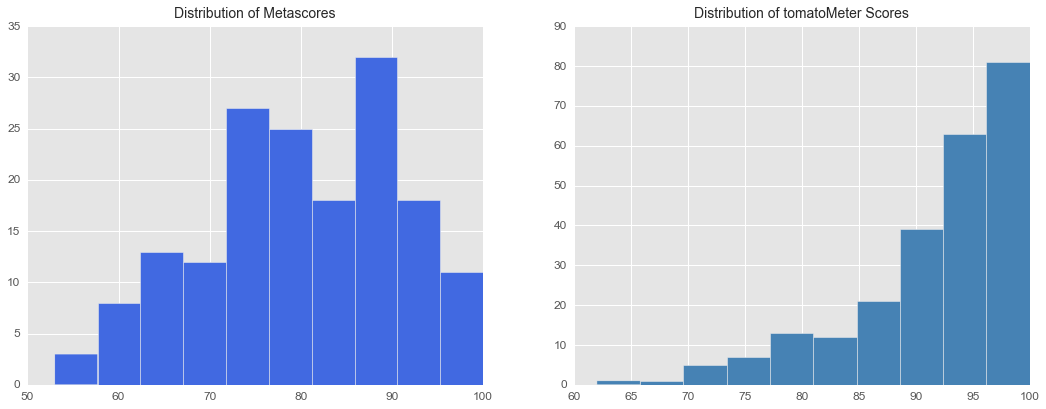

In [371]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,6))

metascore = df[df['Metascore'] > 0]
ax1.hist(metascore['Metascore'], color='royalblue')
ax1.set_title('Distribution of Metascores', \
             fontsize=14, y=1.01)
ax1.tick_params(labelsize=12)

tomatoMeter = df[df['tomatoMeter'] > 0]
ax2.hist(tomatoMeter['tomatoMeter'], color='steelblue')
ax2.set_title('Distribution of tomatoMeter Scores', \
             fontsize=14, y=1.01)
ax2.tick_params(labelsize=12)

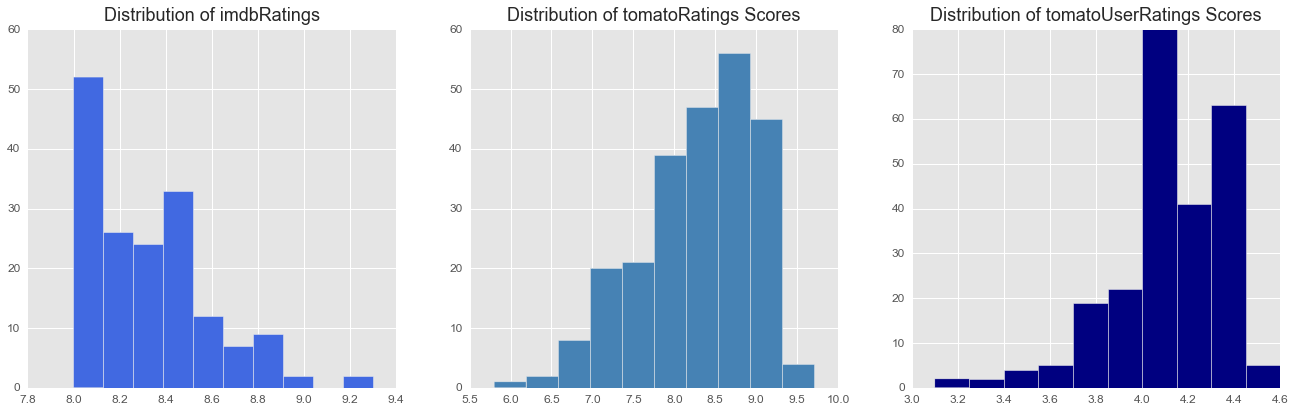

In [391]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

imdbRating = df[df['imdbRating'] > 0]
ax1.hist(metascore['imdbRating'], color='royalblue')
ax1.set_title('Distribution of imdbRatings', \
             fontsize=18, y=1.01)
ax1.tick_params(labelsize=12)

tomatoRating = df[df['tomatoRating'] > 0]
ax2.hist(tomatoMeter['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)
ax2.tick_params(labelsize=12)

tomatoRating = df[df['tomatoRating'] > 0]
ax2.hist(tomatoMeter['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)


tomatoUserRating = df[df['tomatoUserRating'] > 0]
ax3.hist(tomatoMeter['tomatoUserRating'], color='navy')
ax3.set_title('Distribution of tomatoUserRatings Scores', \
             fontsize=18, y=1.01)
ax3.tick_params(labelsize=12)

### Scatterplots

### Unused Separate Histograms

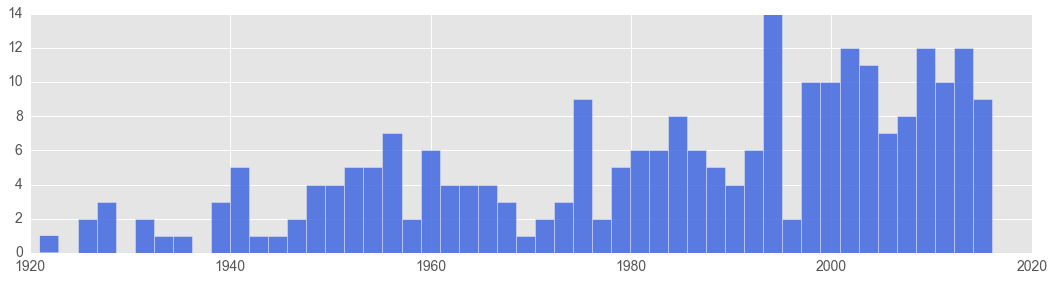

In [572]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}
#data, column=None, by=None, grid=True, xlabelsize=None, 
#xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, 
#sharey=False, figsize=None, layout=None, bins=10, **kwds)¶
xlabel = 14
ylabel = 14
year_bins = 50
df['Year'].hist(figsize=(16,4),xlabelsize=xlabel, ylabelsize=ylabel, bins=bins_dict['Year'],
               facecolor=facecolor_dict['Year'], alpha = .85)

In [ ]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}


def hist_plot(x):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(111)
    n, bins, patches = ax.hist(x,  bins=bins_dict[x], facecolor=facecolor_dict[x], alpha=0.85)
    ax.set_title(axis_titles[x], fontsize=20, y=1.02)
    #ax.set_xticklabels(labels, fontsize=16)
    #ax.set_xticks(labels)
    #ax.set_ylim(0, 16)
    #y_labels = [i for i in range(18) if i%2 == 0]
    #ax.set_yticklabels(y_labels, fontsize=16)

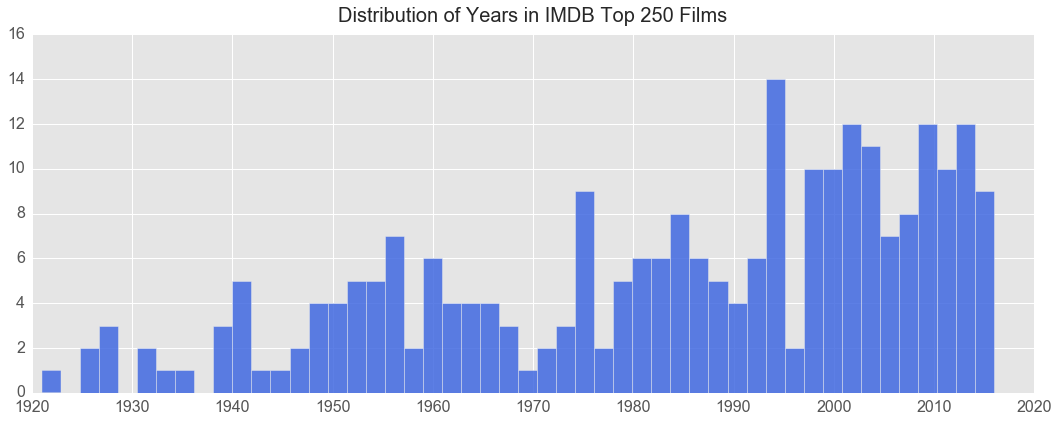

In [525]:
# Years
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Year'],  bins=50, facecolor='royalblue', alpha=0.85)

def decades():
    i = 1910
    labels = []
    while i < 2020:
        labels.append(i + 10)
        i += 10
    return labels
labels = decades()

ax.set_title('Distribution of Years in IMDB Top 250 Films', fontsize=20, y=1.02)
ax.set_xticklabels(labels, fontsize=16)
ax.set_xticks(labels)
ax.set_ylim(0, 16)
y_labels = [i for i in range(18) if i%2 == 0]
ax.set_yticklabels(y_labels, fontsize=16)

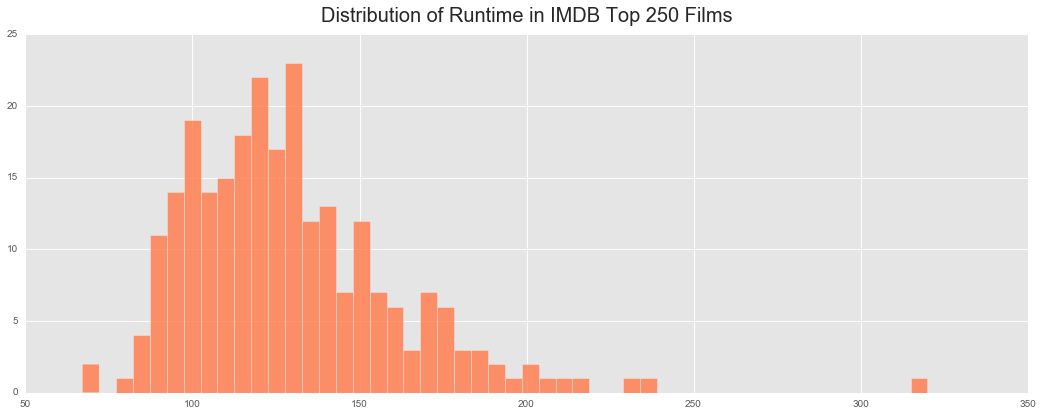

In [286]:
# Runtime
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Runtime'],  bins=50, facecolor='coral', alpha=0.85)

ax.set_title('Distribution of Runtime in IMDB Top 250 Films', fontsize=20, y=1.02)

### Other